# Capture Wikipedia polling data and produce LOWESS charts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Check-raw-data-tallies-to-100%" data-toc-modified-id="Check-raw-data-tallies-to-100%-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check raw data tallies to 100%</a></span><ul class="toc-item"><li><span><a href="#Report-problematic-voting-intention-data" data-toc-modified-id="Report-problematic-voting-intention-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Report problematic voting intention data</a></span></li><li><span><a href="#Report-problematic-attitudinal-data" data-toc-modified-id="Report-problematic-attitudinal-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Report problematic attitudinal data</a></span></li></ul></li><li><span><a href="#Attribute-undecideds-(force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-undecideds-(force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute undecideds (force polls to sum to 100 percent)</a></span></li><li><span><a href="#Calculate-2pp-based-on-preference-flows-at-the-2019-election" data-toc-modified-id="Calculate-2pp-based-on-preference-flows-at-the-2019-election-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate 2pp based on preference flows at the 2019 election</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#Plotting-constants" data-toc-modified-id="Plotting-constants-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plotting constants</a></span></li><li><span><a href="#Plots-with-summary-lines-by-individual-pollsters" data-toc-modified-id="Plots-with-summary-lines-by-individual-pollsters-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plots with summary lines by individual pollsters</a></span></li><li><span><a href="#All-poll-aggregations" data-toc-modified-id="All-poll-aggregations-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>All poll aggregations</a></span></li><li><span><a href="#Close-to-election-plots" data-toc-modified-id="Close-to-election-plots-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Close to election plots</a></span></li><li><span><a href="#Preferred-Prime-Minister" data-toc-modified-id="Preferred-Prime-Minister-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Preferred Prime Minister</a></span></li><li><span><a href="#Satisfaction-charts" data-toc-modified-id="Satisfaction-charts-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Satisfaction charts</a></span></li></ul></li><li><span><a href="#Check-for-under-dispersion-with-poll-results" data-toc-modified-id="Check-for-under-dispersion-with-poll-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Check for under-dispersion with poll results</a></span><ul class="toc-item"><li><span><a href="#Check-all---using-a-simple-arithmetic-mean" data-toc-modified-id="Check-all---using-a-simple-arithmetic-mean-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Check all - using a simple arithmetic mean</a></span></li><li><span><a href="#Check-all-pollsters-but-Essential---against-a-moving-average" data-toc-modified-id="Check-all-pollsters-but-Essential---against-a-moving-average-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Check all pollsters but Essential - against a moving average</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Save files</a></span></li><li><span><a href="#Check-for-any-problems-with-data-capture-and-cleaning" data-toc-modified-id="Check-for-any-problems-with-data-capture-and-cleaning-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Check for any problems with data capture and cleaning</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

# web
import requests

# standard python imports
import platform, sys, os, pathlib
from io import StringIO
from typing import List
import time

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN
from common import P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_OTHER, P_COLOR_GREEN

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed May 18 2022 10:59:34

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

pandas     : 1.4.2
numpy      : 1.22.3
statsmodels: 0.13.2
matplotlib : 3.5.2
platform   : 1.0.8
scipy      : 1.8.0
sys        : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:42:03) [Clang 12.0.1 ]
requests   : 2.27.1

Watermark: 2.3.0



In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = 'Polling data from Wikipedia. '

In [4]:
# saving downloaded files
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

## Get Wikipedia polling data

In [5]:
def get_url_tables(url: str) -> str:
    headers = {
        'Cache-Control': 'no-cache, must-revalidate, private, max-age=0',
        'Pragma': 'no-cache',
    }
    r = requests.get(url.format(rn=time.time()), headers=headers)
    #print(r.headers)
    assert(r.status_code == 200) # successful retrieval
    text = r.text
    return pd.read_html(text)
    
WIKIURL = 'https://en.wikipedia.org/wiki/Opinion_polling_for_the_2022_Australian_federal_election'
table_list = get_url_tables(WIKIURL)

In [6]:
#table_list[13]

In [7]:
def extract_polling_tables(table_list):
    sought = {
        # description:              table numbers in table_list
        "Voting intention":         [1, 2],
        "Preferred prime minister": [13],
    }

    table_dict = {}
    for item, table_numbers in sought.items():
        captured = []
        returnable = None
        for table_number in table_numbers:
            table = table_list[table_number]
            returnable = table if returnable is None else pd.concat([returnable, table])
        table_dict[item] = returnable
    return table_dict

table_dict = extract_polling_tables(table_list)

In [8]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(f'{key} (length={len(table)})')
    display(table.iloc[:15])
    print('=' * 40)

Voting intention (length=163)


Date                  Brand       Interview mode  \
                 Date                  Brand       Interview mode   
0      12–17 May 2022   Resolve Strategic[6]     Telephone/online   
1      14–16 May 2022           Essential[7]               Online   
2       9–15 May 2022          Roy Morgan[8]     Telephone/online   
3      10–13 May 2022     Newspoll-YouGov[9]               Online   
4          9 May 2022    Early voting begins  Early voting begins   
5        2–8 May 2022         Roy Morgan[10]     Telephone/online   
6        4–7 May 2022    Newspoll-YouGov[11]               Online   
7        4–7 May 2022              Ipsos[12]     Telephone/online   
8   25 Apr–1 May 2022         Roy Morgan[13]     Telephone/online   
9      27–30 Apr 2022          Essential[14]               Online   
10     27–30 Apr 2022    Newspoll-YouGov[15]               Online   
11     27–30 Apr 2022  Resolve Strategic[16]               Online   
12     18–24 Apr 2022         Roy Morgan[17]     Telephone/online   
13     20–23 Apr 2022    Newspoll-YouGov[18]               Online   
14     20–23 Apr 2022              Ipsos[19]     Telephone/online   

            Sample size         Primary vote                       \
            Sample size                 L/NP                  ALP   
0                  2049                  34%                  31%   
1                  1600                  36%                  35%   
2                  1366                  34%                  34%   
3                  1532                  35%                  38%   
4   Early voting begins  Early voting begins  Early voting begins   
5                  1401                  34%                35.5%   
6                  1523                  35%                  39%   
7                  2311                  29%                  35%   
8                  1487                  35%                  35%   
9                  1500                  36%                  35%   
10                 1538                  36%                  38%   
11                 1408                  33%                  34%   
12                 1393                35.5%                  35%   
13                 1538                  36%                  37%   
14                 2302                  32%                  34%   

                                                                   \
                    GRN                  ONP                  UAP   
0                   14%                   6%                   4%   
1                    9%                   4%                   3%   
2                   13%                   4%                   1%   
3                   11%                   6%                   3%   
4   Early voting begins  Early voting begins  Early voting begins   
5                   13%                   4%                   1%   
6                   11%                   5%                   4%   
7                   12%                   4%                   3%   
8                   13%                   3%                   1%   
9                   10%                   3%                   4%   
10                  11%                   5%                   4%   
11                  15%                   5%                   5%   
12                  12%                 4.5%                 1.5%   
13                  11%                   3%                   4%   
14                  12%                   4%                   3%   

                                    2pp vote                       \
                    OTH                  UND                 L/NP   
0                10%[a]                    —                  49%   
1                 6%[b]                   7%                  46%   
2                   14%                    —                  47%   
3                    7%                    —                  46%   
4   Early voting begins  Early voting begins  Early voting begins   
5           

Preferred prime minister (length=59)


Date                          Brand               Firm  \
                 Date                          Brand               Firm   
0      10–13 May 2022                       Newspoll             YouGov   
1        4–7 May 2022                   Newspoll[11]             YouGov   
2        4–7 May 2022                      Ipsos[12]              Ipsos   
3      27–30 Apr 2022                   Newspoll[15]             YouGov   
4      20–23 Apr 2022                   Newspoll[18]             YouGov   
5      20–23 Apr 2022                      Ipsos[19]              Ipsos   
6      17–20 Apr 2022                  Essential[20]          Essential   
7      11–16 Apr 2022  Resolve Political Monitor[23]  Resolve Strategic   
8        6–9 Apr 2022                   Newspoll[25]             YouGov   
9   31 Mar–3 Apr 2022      Resolve Political Monitor  Resolve Strategic   
10  31 Mar–3 Apr 2022                       Newspoll             YouGov   
11  31 Mar–2 Apr 2022                          Ipsos              Ipsos   
12      9–12 Mar 2022                   Newspoll[35]             YouGov   
13     23–26 Feb 2022                   Newspoll[38]             YouGov   
14     17–20 Feb 2022                  Essential[41]          Essential   

      Interview mode Sample size Preferred Prime Minister                      \
      Interview mode Sample size                 Morrison Albanese Don't Know   
0             Online        1532                      43%      42%        15%   
1   Telephone/online        1538                      44%      42%        14%   
2   Telephone/Online        2311                      36%      41%        24%   
3   Telephone/online        1538                      45%      39%        17%   
4   Telephone/Online        1538                      46%      37%        17%   
5   Telephone/Online        2302                      38%      40%        22%   
6             Online        1052                      40%      36%        24%   
7             Online        1404                      38%      30%        32%   
8             Online        1506                      44%      39%        17%   
9             Online        1681                      36%      37%        15%   
10            Online        1531                      43%      42%        15%   
11  Telephone/Online        2563                      37%      38%        25%   
12            Online        1520                      42%      42%        16%   
13            Online        1525                      42%      40%        18%   
14            Online        1089                      40%      35%        25%   

    Morrison                          Albanese                          
   Satisfied Dissatisfied Don't Know Satisfied Dissatisfied Don't Know  
0        42%          53%         5%       38%          49%        13%  
1        41%          55%         4%       41%          47%        12%  
2        32%          51%        18%       30%          36%        34%  
3        44%          51%         5%       40%          49%        12%  
4        42%          54%         4%       38%          50%        12%  
5        34%          48%        18%       31%          35%        34%  
6        44%          48%         8%       41%          41%        17%  
7        44%          47%         9%       35%          44%        21%  
8        42%          54%         4%       42%          45%        13%  
9        39%          53%         8%       38%          42%        20%  
10       42%          54%         4%       43%          44%        13%  
11       33%          48%        19%       30%          32%        38%  
12       41%          55%         4%       44%          42%        14%  
13       43%          55%         2%       44%          43%        13%  
14       44%          49%         7%       43%          40%        17%

## Data cleaning

In [9]:
cleaned = {}
for key, table in table_dict.items():
    print(key)
    cleaned[key] = common.clean(table)
    display(cleaned[key].tail(3))

Voting intention


Date              Brand    Interview mode  \
                         Date              Brand    Interview mode   
(Mean Date, )                                                        
2022-05-12      9–15 May 2022         Roy Morgan  Telephone/online   
2022-05-14     12–17 May 2022  Resolve Strategic  Telephone/online   
2022-05-15     14–16 May 2022          Essential            Online   

              Sample size Primary vote                             2pp vote  \
              Sample size         L/NP   ALP   GRN  ONP  UAP   OTH      UND   
(Mean Date, )                                                                 
2022-05-12         1366.0         34.0  34.0  13.0  4.0  1.0  14.0      NaN   
2022-05-14         2049.0         34.0  31.0  14.0  6.0  4.0  10.0      NaN   
2022-05-15         1600.0         36.0  35.0   9.0  4.0  3.0   6.0      7.0   

                           
               L/NP   ALP  
(Mean Date, )              
2022-05-12     47.0  53.0  
2022-05-14     49.0  51.0  
2022-05-15     46.0  48.0

Preferred prime minister


Date     Brand    Firm    Interview mode Sample size  \
                         Date     Brand    Firm    Interview mode Sample size   
(Mean Date, )                                                                   
2022-05-05       4–7 May 2022     Ipsos   Ipsos  Telephone/Online      2311.0   
2022-05-05       4–7 May 2022  Newspoll  YouGov  Telephone/online      1538.0   
2022-05-11     10–13 May 2022  Newspoll  YouGov            Online      1532.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2022-05-05                        36.0     41.0       24.0      32.0   
2022-05-05                        44.0     42.0       14.0      41.0   
2022-05-11                        43.0     42.0       15.0      42.0   

                                       Albanese                          
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know  
(Mean Date, )                                                            
2022-05-05            51.0       18.0      30.0         36.0       34.0  
2022-05-05            55.0        4.0      41.0         47.0       12.0  
2022-05-11            53.0        5.0      38.0         49.0       13.0

## Check raw data tallies to 100%

In [10]:
def check_row_sums(df: pd.DataFrame, columns: str) -> None:
    """Identify when rows do not add to 100%."""
    
    row_totals = (
        df[
            df.columns[
                df
                .columns
                .get_level_values(0) == columns
            ]
        ]
        .sum(axis=1, skipna=True)
    )
    problematic = (row_totals != 0) & ((row_totals < 99) | (row_totals > 101))

    # If any rows have any row-addition problem ... let's report them
    if problematic.any():
        common.warn(f'check_row_sums() found issues with {columns}')
        output = df.copy()
        output[(columns, 'ROW TOTALS')] = row_totals
        display(output[problematic])
        print('=' * 50)
        del output

### Report problematic voting intention data

Note: 
*  Essential and Ipsos do not attribute undecideds to 2pp. So their 2pp totals do not total to 100%
*  More problematic is the primary votes that do not total to 100%

In [11]:
vi = cleaned['Voting intention'].copy()
attitudinal = cleaned['Preferred prime minister'].copy()

check_row_sums(vi, '2pp vote')
check_row_sums(vi, 'Primary vote')


check_row_sums() found issues with 2pp vote


Date  Brand    Interview mode Sample size  \
                         Date  Brand    Interview mode Sample size   
(Mean Date, )                                                        
2022-04-21     20–23 Apr 2022  Ipsos  Telephone/online      2302.0   
2022-05-05       4–7 May 2022  Ipsos  Telephone/online      2311.0   

              Primary vote                             2pp vote              \
                      L/NP   ALP   GRN  ONP  UAP   OTH      UND  L/NP   ALP   
(Mean Date, )                                                                 
2022-04-21            32.0  34.0  12.0  4.0  3.0   8.0      8.0  45.0  55.0   
2022-05-05            29.0  35.0  12.0  4.0  3.0  10.0      7.0  43.0  57.0   

                          
              ROW TOTALS  
(Mean Date, )             
2022-04-21         108.0  
2022-05-05         107.0

check_row_sums() found issues with Primary vote


Date      Brand    Interview mode Sample size  \
                            Date      Brand    Interview mode Sample size   
(Mean Date, )                                                               
2020-01-27     20 Jan–3 Feb 2020        ANU       CATI/online      3249.0   
2020-06-08            8 Jun 2020  Essential            Online      1073.0   
2020-06-15           15 Jun 2020  Essential            Online      1087.0   
2020-06-22           22 Jun 2020  Essential            Online      1079.0   
2020-06-29           29 Jun 2020  Essential            Online      1079.0   
2020-07-13           13 Jul 2020  Essential            Online      1054.0   
2020-07-24        23–26 Jul 2020  Essential            Online      1058.0   
2020-08-10           10 Aug 2020  Essential            Online         NaN   
2020-08-24           24 Aug 2020  Essential            Online         NaN   
2020-09-07            7 Sep 2020  Essential            Online         NaN   
2020-09-21           21 Sep 2020  Essential            Online         NaN   
2020-10-05            5 Oct 2020  Essential            Online         NaN   
2020-10-12           12 Oct 2020  Essential            Online         NaN   
2020-10-16        14–19 Oct 2020  Essential            Online         NaN   
2020-11-02            2 Nov 2020  Essential            Online         NaN   
2020-11-16           16 Nov 2020  Essential            Online         NaN   
2020-11-30           30 Nov 2020  Essential            Online         NaN   
2020-12-14           14 Dec 2020  Essential            Online         NaN   
2021-01-18           18 Jan 2021  Essential            Online         NaN   
2021-01-29     27 Jan–1 Feb 2021  Essential            Online      1092.0   
2021-02-15           15 Feb 2021  Essential            Online         NaN   
2021-03-01            1 Mar 2021  Essential            Online         NaN   
2021-03-15           15 Mar 2021  Essential            Online         NaN   
2021-03-29           29 Mar 2021  Essential            Online         NaN   
2021-04-12           12 Apr 2021  Essential            Online         NaN   
2021-04-26           26 Apr 2021  Essential            Online         NaN   
2021-05-10           10 May 2021  Essential            Online         NaN   
2021-05-24           24 May 2021  Essential            Online         NaN   
2021-06-07            7 Jun 2021  Essential            Online         NaN   
2021-06-21           21 Jun 2021  Essential            Online         NaN   
2021-07-05            5 Jul 2021  Essential            Online         NaN   
2021-07-19           19 Jul 2021  Essential            Online         NaN   
2021-08-02            2 Aug 2021  Essential            Online         NaN   
2021-08-16           16 Aug 2021  Essential            Online         NaN   
2021-08-27        25–29 Aug 2021  Essential            Online      1100.0   
2021-09-10         8–12 Sep 2021  Essential            Online      1100.0   
2021-09-24        22–26 Sep 2021  Essential            Online      1094.0   
2021-10-08         6–10 Oct 2021  Essential            Online      1097.0   
2021-10-22        20–24 Oct 2021  Essential            Online      1781.0   
2021-11-05          3–7 Nov 2021  Essential            Online      1089.0   
2021-11-19        17–21 Nov 2021  Essential            Online      1095.0   
2021-12-03          1–5 Dec 2021  Essential            Online      1094.0   
2021-12-10         8–13 Dec 2021  Essential            Online      1095.0   
2022-01-21        20–23 Jan 2022  Essential            Online      1062.0   
2022-02-04          2–6 Feb 2022  Essential            Online      1069.0   
2022-02-18        17–20 Feb 2022  Essential            Online      1089.0   
2022-03-04          2–6 Mar 2022  Essential            Online      1093.0   
2022-03-18        17–20 Mar 2022  Essential            Online      1091.0   
2022-03-31     30 Mar–2 Apr 2022      Ipsos  Telephone/online      2563.0   
2022-03-31     30 Mar–2 

### Report problematic attitudinal data

In [12]:
check_row_sums(attitudinal, 'Preferred Prime Minister')
check_row_sums(attitudinal, 'Morrison')
check_row_sums(attitudinal, 'Albanese')

check_row_sums() found issues with Preferred Prime Minister


Date                      Brand  \
                            Date                      Brand   
(Mean Date, )                                                 
2022-04-01     31 Mar–3 Apr 2022  Resolve Political Monitor   

                            Firm Interview mode Sample size  \
                            Firm Interview mode Sample size   
(Mean Date, )                                                 
2022-04-01     Resolve Strategic         Online      1681.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2022-04-01                        36.0     37.0       15.0      39.0   

                                       Albanese                          \
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know   
(Mean Date, )                                                             
2022-04-01            53.0        8.0      38.0         42.0       20.0   

              Preferred Prime Minister  
                            ROW TOTALS  
(Mean Date, )                           
2022-04-01                        88.0

check_row_sums() found issues with Albanese


Date                      Brand               Firm  \
                         Date                      Brand               Firm   
(Mean Date, )                                                                 
2020-08-06       5–8 Aug 2020                   Newspoll             YouGov   
2022-01-13     11–15 Jan 2022  Resolve Political Monitor  Resolve Strategic   

              Interview mode Sample size Preferred Prime Minister           \
              Interview mode Sample size                 Morrison Albanese   
(Mean Date, )                                                                
2020-08-06            Online      1509.0                     60.0     25.0   
2022-01-13            Online      1607.0                     38.0     31.0   

                          Morrison                          Albanese  \
              Don't Know Satisfied Dissatisfied Don't Know Satisfied   
(Mean Date, )                                                          
2020-08-06          15.0      68.0         29.0        3.0      41.0   
2022-01-13          31.0      41.0         50.0        9.0      34.0   

                                                  
              Dissatisfied Don't Know ROW TOTALS  
(Mean Date, )                                     
2020-08-06            38.0       15.0       94.0  
2022-01-13            41.0       28.0      103.0

## Attribute undecideds (force polls to sum to 100 percent)

And remove the hierarchical index

In [13]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    if (column, 'UND') in data.columns:
        data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [14]:
vi = cleaned['Voting intention'].reset_index()

tpp = attribute('2pp vote', vi).copy()
tpp.columns = common.flatten_col_names(tpp.columns)
tpp = tpp[tpp['2pp vote L/NP'].notna()] # remove nans

pv = attribute('Primary vote', vi).copy()
pv.columns = common.flatten_col_names(pv.columns)
pv = pv[pv['Primary vote L/NP'].notna()] # remove nans

ppm = cleaned['Preferred prime minister'].reset_index().copy()
ppm.columns = common.flatten_col_names(ppm.columns)

del vi

In [15]:
ppm.columns

Index(['Mean Date', 'Date', 'Brand', 'Firm', 'Interview mode', 'Sample size',
       'Preferred Prime Minister Morrison',
       'Preferred Prime Minister Albanese',
       'Preferred Prime Minister Don't Know', 'Morrison Satisfied',
       'Morrison Dissatisfied', 'Morrison Don't Know', 'Albanese Satisfied',
       'Albanese Dissatisfied', 'Albanese Don't Know'],
      dtype='object')

In [16]:
# quick check, does the adjusted primary vote tally to 100%
columns = pv.columns[pv.columns.str.contains('Primary vote')]
row_sums = pv[columns].sum(axis=1)
check = (row_sums < 99.9) | (row_sums > 100.1)
if check.any():
    common.warn(f'Problematic primary vote polling data')
    pv[check]
    row_sums[check]

In [17]:
# A quick sanity check on the final tables ...
# Are the values within the typical long-run expectations
def final_sanity_check():
    checker = {
        # column: [in-DataFrame, middle-value, plus-or-minus-span]
        '2pp vote L/NP': [tpp, 50, 6],
        '2pp vote ALP': [tpp, 50, 6],
        'Primary vote L/NP': [pv, 39, 7],
        'Primary vote ALP': [pv, 39, 8],
        'Primary vote GRN': [pv, 12, 7],
        'Primary vote OTH': [pv, 12, 7],
        'Primary vote UAP': [pv, 4, 3.5],
        'Primary vote ONP': [pv, 4, 3.5],
    }

    # check for any odd rows
    for col, (df, target, threshold) in checker.items():
        odd = df[col].notna() & ((df[col] - target).abs() > threshold)
        if odd.sum():
            common.warn(f'final_sanity_check() found an issue with "{col}"')
            display(df[odd])

final_sanity_check()

final_sanity_check() found an issue with "2pp vote L/NP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 Nov, 4–5 Dec 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 Jan 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 Jan–13 Feb 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 Feb 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 Feb–3 Mar 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 Mar 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 Mar–3 Apr 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
136,43.0,57.0,4–10 Apr 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0
149,43.0,57.0,4–7 May 2022,2022-05-05,Ipsos,Telephone/online,2311.0


final_sanity_check() found an issue with "2pp vote ALP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 Nov, 4–5 Dec 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 Jan 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 Jan–13 Feb 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 Feb 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 Feb–3 Mar 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 Mar 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 Mar–3 Apr 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
136,43.0,57.0,4–10 Apr 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0
149,43.0,57.0,4–7 May 2022,2022-05-05,Ipsos,Telephone/online,2311.0


final_sanity_check() found an issue with "Primary vote L/NP"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
128,31.000000,37.500000,12.000000,3.000000,1.000000,15.500000,14–20 Mar 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
149,31.182796,37.634409,12.903226,4.301075,3.225806,10.752688,4–7 May 2022,2022-05-05,Ipsos,Telephone/online,2311.0


final_sanity_check() found an issue with "Primary vote OTH"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
121,37.234043,40.425532,9.574468,5.319149,3.191489,4.255319,17–20 Feb 2022,2022-02-18,Essential,Online,1089.0
125,39.560440,38.461538,10.989011,3.296703,3.296703,4.395604,2–6 Mar 2022,2022-03-04,Essential,Online,1093.0
129,40.217391,40.217391,9.782609,3.260870,2.173913,4.347826,17–20 Mar 2022,2022-03-18,Essential,Online,1091.0


## Calculate 2pp based on preference flows at the 2019 election

In [18]:
vote_transfer = """
from,              transfer to L/NP, transfer to ALP
Primary vote L/NP, 0.999,             0.001
Primary vote ALP,  0.0,               1.0
Primary vote GRN,  0.178,             0.822
Primary vote ONP,  0.652,             0.348
Primary vote UAP,  0.651,             0.349
Primary vote OTH,  0.493,             0.507
"""
# see: https://antonygreen.com.au/preference-flows-at-the-2019-federal-election/


vt = pd.read_csv(StringIO(vote_transfer), header=0, index_col=0,
                  skipinitialspace=True)

# Check that the rows in this table all sum to 1
if not (vt.sum(axis=1) == 1.0).all():
    common.warn('Check the primary vote transfer table used for calculating 2pp')

In [19]:
CALC_TPP_LNP, CALC_TPP_ALP = 'Calculated 2pp L/NP', 'Calculated 2pp ALP'
pv[CALC_TPP_LNP] = pv[vt.index].mul(vt['transfer to L/NP'], axis=1).sum(axis=1)
pv[CALC_TPP_ALP] = pv[vt.index].mul(vt['transfer to ALP'], axis=1).sum(axis=1)

# let's look at the last few rows
pv.tail(3)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
153,34.000000,34.000000,13.000000,4.000000,1.000000,14.000000,9–15 May 2022,2022-05-12,Roy Morgan,Telephone/online,1366.0,46.441000,53.559000
154,34.343434,31.313131,14.141414,6.060606,4.040404,10.101010,12–17 May 2022,2022-05-14,Resolve Strategic,Telephone/online,2049.0,48.387879,51.612121
155,38.709677,37.634409,9.677419,4.301075,3.225806,6.451613,14–16 May 2022,2022-05-15,Essential,Online,1600.0,48.478495,51.521505


In [20]:
# check calculated TPP adds to 100%
sums = pv[[CALC_TPP_LNP, CALC_TPP_ALP]].sum(axis=1)
check = (sums < 99.9) | (sums > 100.1)
if any(check):
    common.warn(f'Problematic calculation of 2pp vote share from primary vote polling')
    pv[check]
    sums[check]

In [21]:
# let's look at the more than one percentage point mismatch rows with pollster calculated 2pp
combo = pv.copy()
del combo['Calculated 2pp ALP']
combo['2pp vote L/NP'] = tpp['2pp vote L/NP']
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() >= 1.0
combo[problematic]

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
29,42.222222,37.777778,10.000000,4.444444,NaN,5.555556,10 Aug 2020,2020-08-10,Essential,Online,NaN,49.596667,51.111111
31,41.935484,37.634409,9.677419,4.301075,NaN,6.451613,24 Aug 2020,2020-08-24,Essential,Online,NaN,49.601075,51.086957
33,41.304348,34.782609,10.869565,3.260870,NaN,9.782609,7 Sep 2020,2020-09-07,Essential,Online,NaN,50.146739,48.913043
35,45.054945,34.065934,10.989011,4.395604,NaN,5.494505,21 Sep 2020,2020-09-21,Essential,Online,NaN,52.540659,53.846154
39,41.935484,37.634409,9.677419,3.225806,NaN,7.526882,14–19 Oct 2020,2020-10-16,Essential,Online,NaN,49.430108,51.612903
45,44.565217,35.869565,8.695652,4.347826,NaN,6.521739,30 Nov 2020,2020-11-30,Essential,Online,NaN,52.118478,53.260870
78,39.784946,38.709677,10.752688,4.301075,NaN,6.451613,19 Jul 2021,2021-07-19,Essential,Online,NaN,47.644086,48.913043
83,40.659341,39.560440,9.890110,3.296703,NaN,6.593407,16 Aug 2021,2021-08-16,Essential,Online,NaN,47.779121,48.913043
102,38.888889,41.111111,10.000000,3.333333,NaN,6.666667,3–7 Nov 2021,2021-11-05,Essential,Online,1089.0,46.090000,48.888889
104,35.500000,35.500000,12.000000,3.500000,NaN,13.500000,"13–14, 20–21 Nov 2021",2021-11-17,Roy Morgan,Telephone/online,2795.0,46.538000,44.500000


In [22]:
# warn if the mismatch is greater than 2.5 percentage points
THRESHOLD = 2.5
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() > THRESHOLD
if problematic.sum():
    common.warn('There is a substantial mismatch with pollster 2pp at\n\t'
         f'{combo.loc[problematic, "Mean Date"].dt.date.values}')
    display(combo[problematic])

There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
102,38.888889,41.111111,10.0,3.333333,NaN,6.666667,3–7 Nov 2021,2021-11-05,Essential,Online,1089.0,46.09,48.888889


In [23]:
pv.tail(15)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
141,39.784946,37.634409,9.677419,3.225806,4.301075,5.376344,19–20 Apr 2022,2022-04-19,Essential,Online,1052.0,49.021505,50.978495
142,34.408602,36.559140,12.903226,4.301075,3.225806,8.602151,20–23 Apr 2022,2022-04-21,Ipsos,Telephone/online,2302.0,45.816129,54.183871
143,36.000000,37.000000,11.000000,3.000000,4.000000,9.000000,20–23 Apr 2022,2022-04-21,Newspoll-YouGov,Online,1538.0,46.919000,53.081000
144,35.500000,35.000000,12.000000,4.500000,1.500000,11.500000,18–24 Apr 2022,2022-04-21,Roy Morgan,Telephone/online,1393.0,47.180500,52.819500
145,38.709677,37.634409,10.752688,3.225806,4.301075,5.376344,27–30 Apr 2022,2022-04-28,Essential,Online,1500.0,48.138710,51.861290
146,35.000000,35.000000,13.000000,3.000000,1.000000,13.000000,25 Apr–1 May 2022,2022-04-28,Roy Morgan,Telephone/online,1487.0,46.295000,53.705000
147,33.000000,34.000000,15.000000,5.000000,5.000000,8.000000,27–30 Apr 2022,2022-04-28,Resolve Strategic,Online,1408.0,46.096000,53.904000
148,36.000000,38.000000,11.000000,5.000000,4.000000,6.000000,27–30 Apr 2022,2022-04-28,Newspoll-YouGov,Online,1538.0,46.744000,53.256000
149,31.182796,37.634409,12.903226,4.301075,3.225806,10.752688,4–7 May 2022,2022-05-05,Ipsos,Telephone/online,2311.0,43.653763,56.346237
150,35.000000,39.000000,11.000000,5.000000,4.000000,6.000000,4–7 May 2022,2022-05-05,Newspoll-YouGov,Online,1523.0,45.745000,54.255000


## Quick plots

In [24]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')


### Plotting constants

In [25]:
# constants ...
HALF_LIFE_DAYS = 14 # days
HALF_LIFE = pd.Timedelta(days=HALF_LIFE_DAYS)
LOWESS_PERIOD = 120 # days

# For primaries vote polls ...
PARTIES = ['Coalition', 'Labor', 'Greens', 'Other']
COLUMNS = ['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
           ['Primary vote ONP', 'Primary vote OTH']]
L_COLORS = [COLOR_COALITION, COLOR_LABOR, COLOR_GREEN, COLOR_OTHER]
P_COLORS = [P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_GREEN, P_COLOR_OTHER]

# For 2pp polls ...
TPP_PARTIES = ('Coalition', 'Labor')
TPP_P_COLORS = (P_COLOR_COALITION, P_COLOR_LABOR)
TPP_L_COLORS = (COLOR_COALITION, COLOR_LABOR)

# 
FUNCTIONS = common.calculate_ewm, common.calculate_lowess,
ARGUMENTS = HALF_LIFE, LOWESS_PERIOD
LFOOTERS = (
    LFOOTER + f'; Half-life = {HALF_LIFE_DAYS} days', 
    LFOOTER + f'; LOWESS period = {LOWESS_PERIOD} days'
)
TITLE_STEMS = 'Exponentially Weighted Poll Average', 'LOWESS Regression'

### Plots with summary lines by individual pollsters

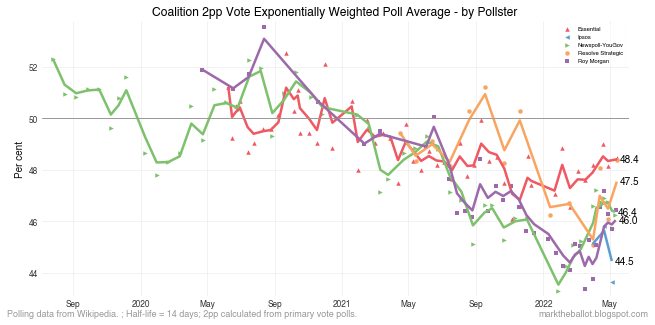

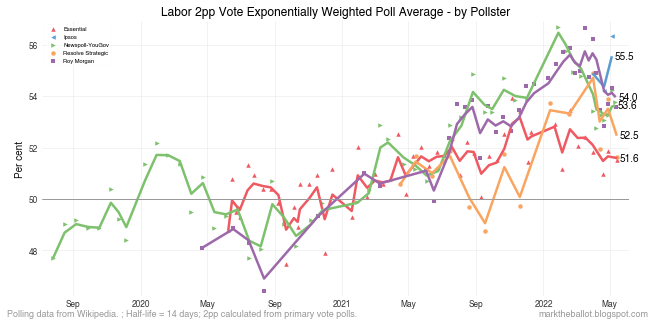

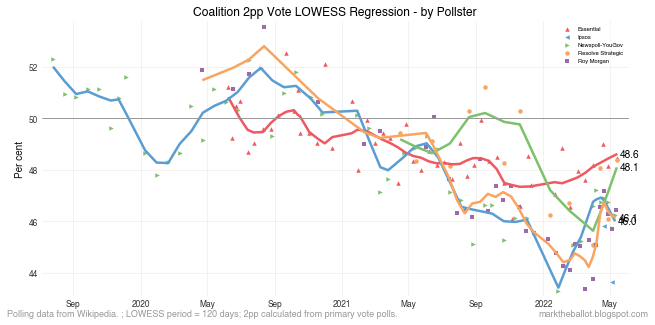

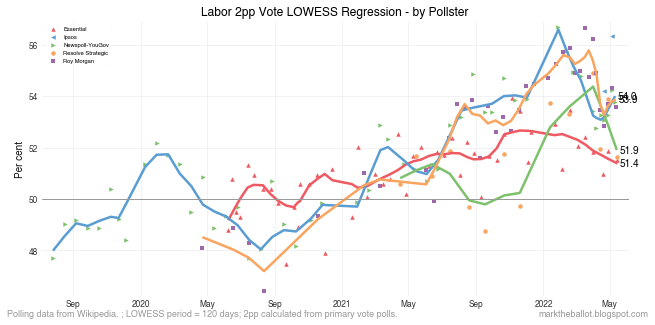

In [26]:
# 2pp ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')

llfooter = '; 2pp calculated from primary vote polls.'
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(TPP_PARTIES, TPP_COLUMNS):
        title = f'{party} 2pp Vote {stem} - by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter+llfooter)        


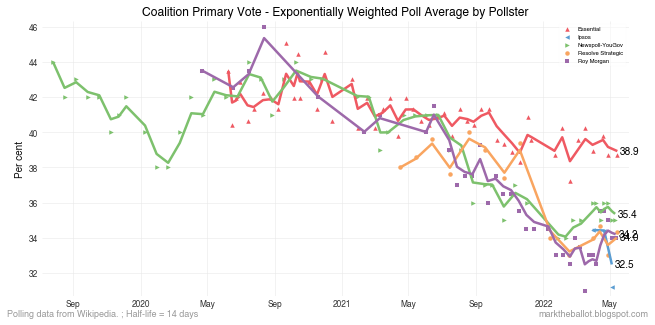

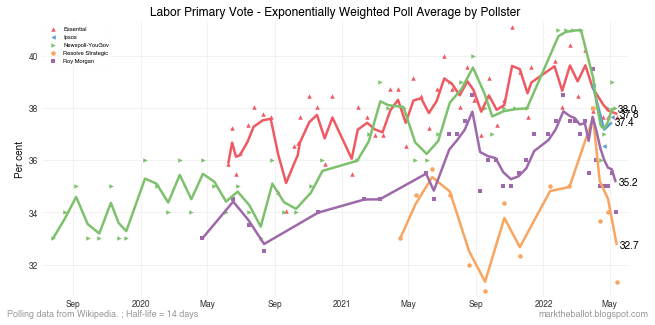

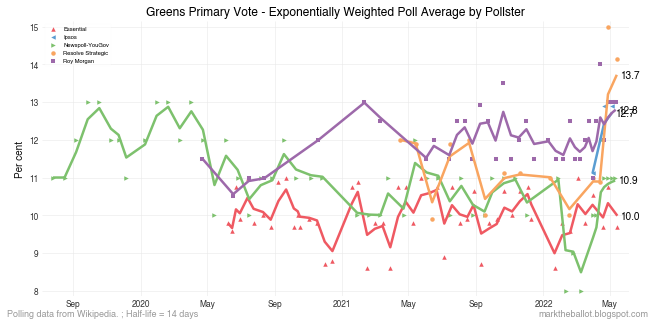

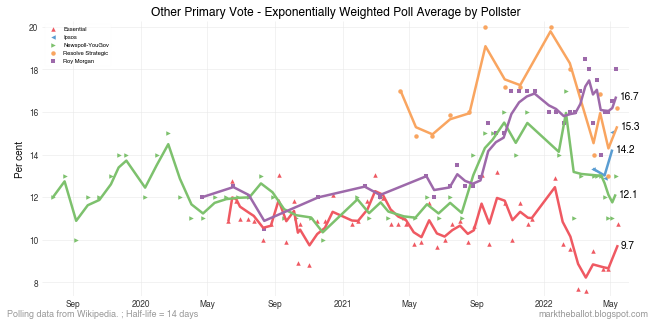

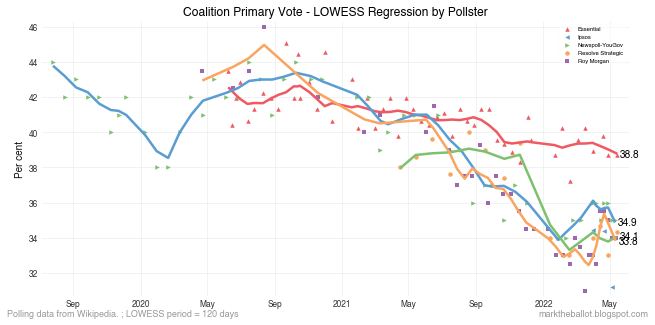

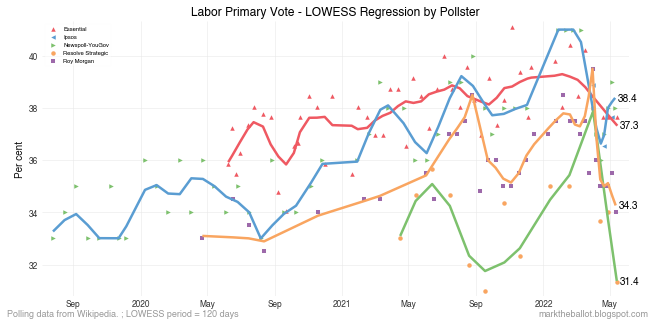

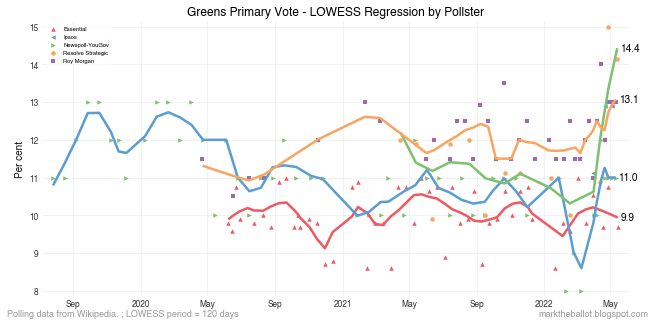

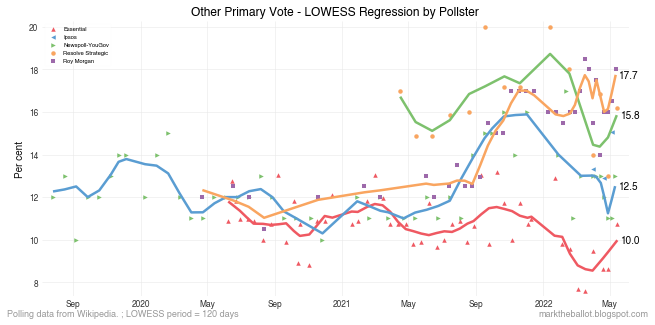

In [27]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(PARTIES, COLUMNS):
        title = f'{party} Primary Vote - {stem} by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter)        

### All poll aggregations

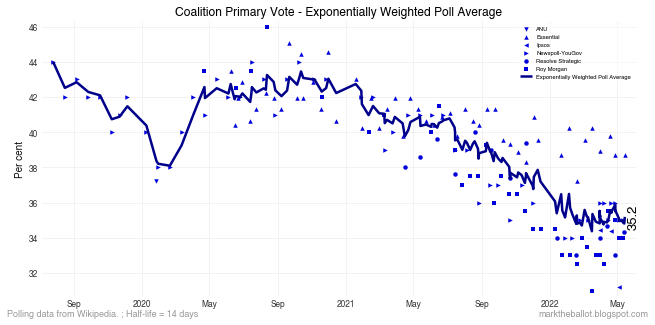

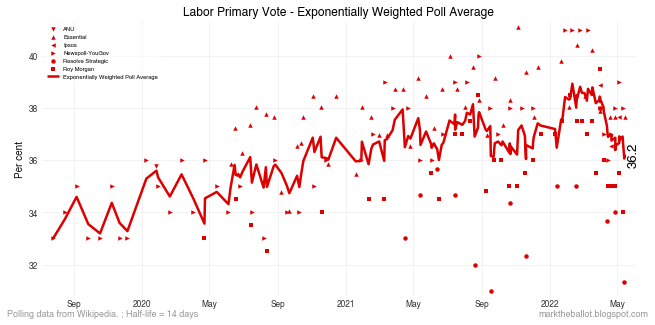

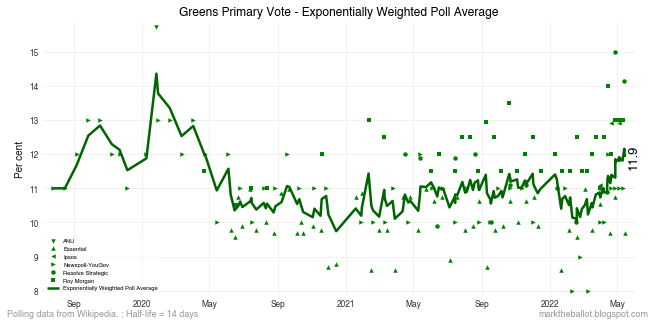

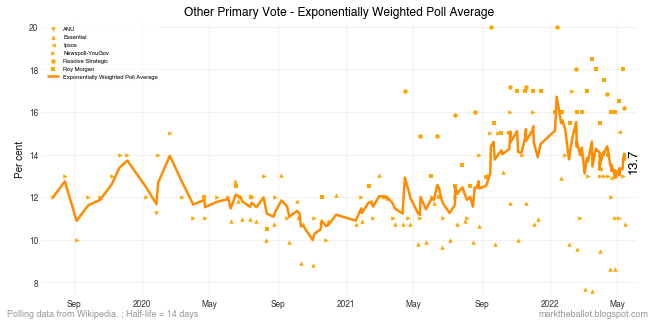

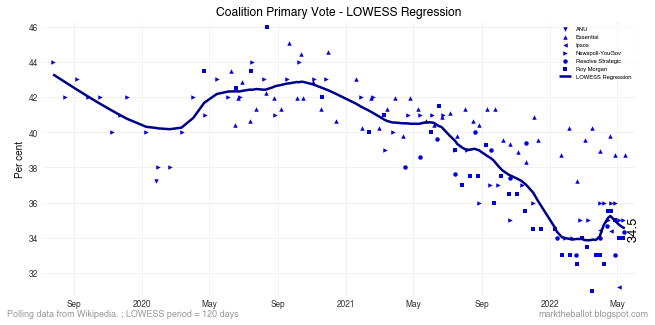

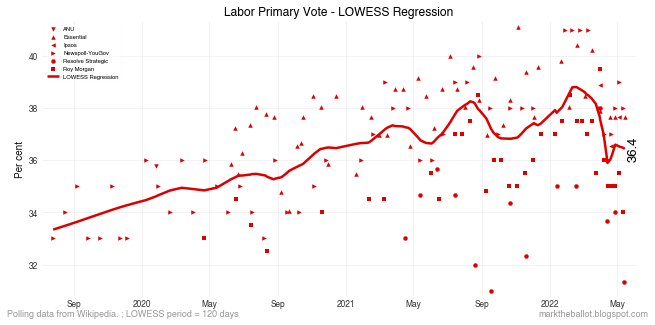

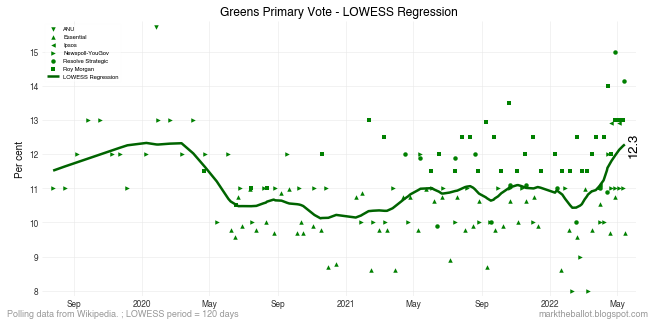

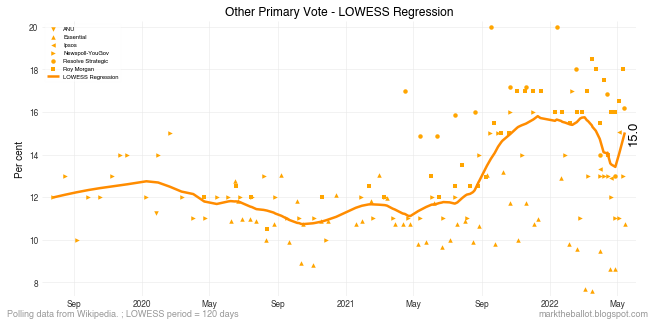

In [28]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(PARTIES, COLUMNS, P_COLORS, L_COLORS):
        title = f'{party} Primary Vote - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)


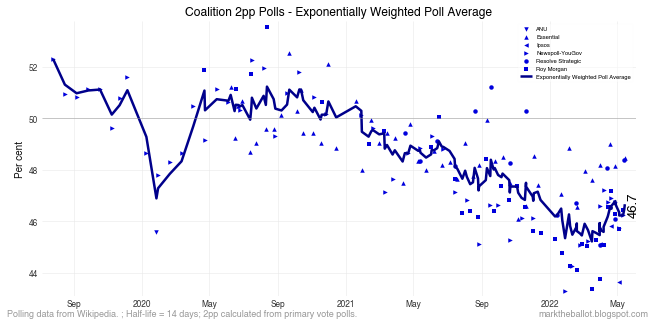

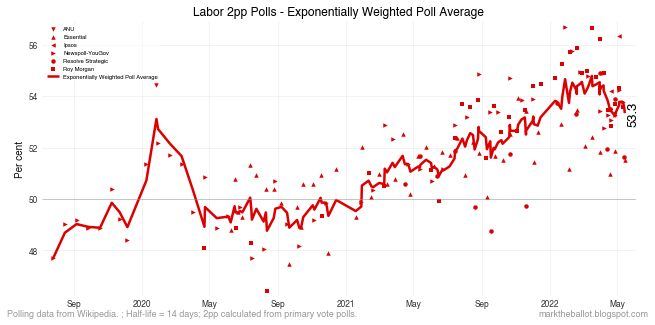

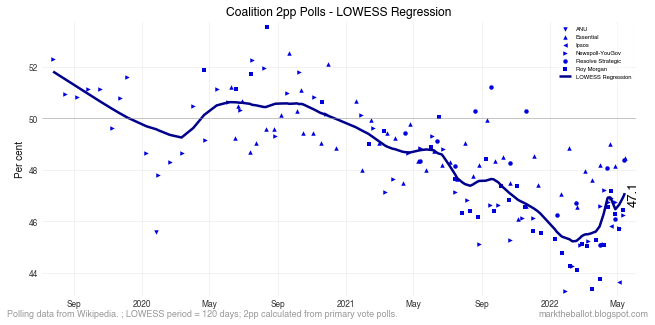

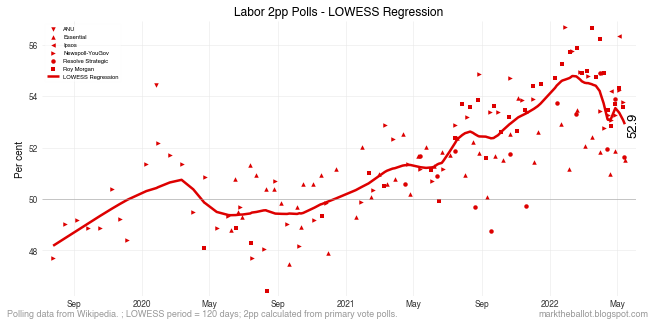

In [29]:
# 2pp, as calculated by me ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')
llfooter = '; 2pp calculated from primary vote polls.'

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Polls - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter+llfooter)

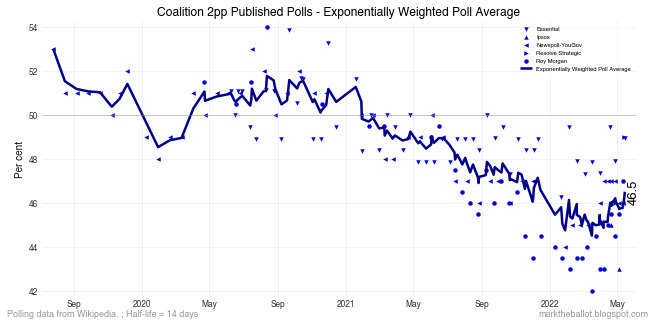

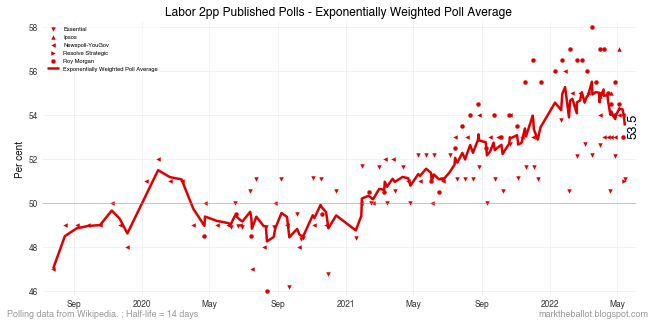

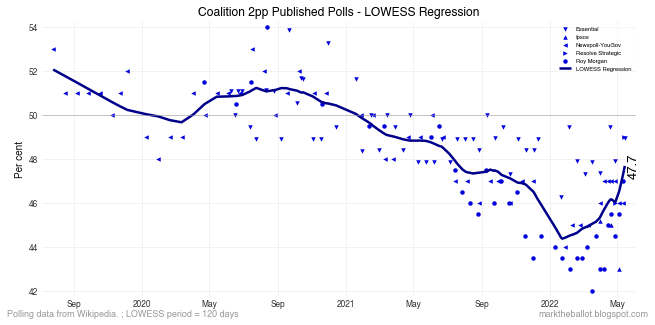

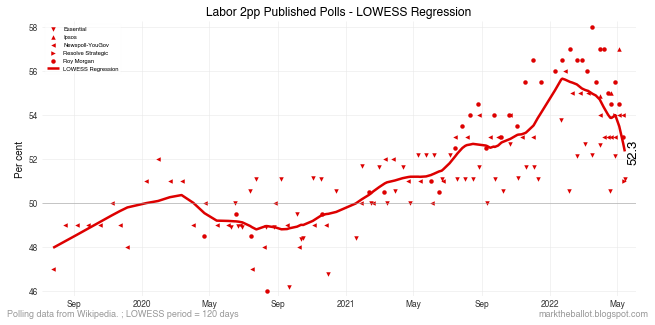

In [30]:
# 2pp, as published by pollsters ...
TPP_COLUMNS = ('2pp vote L/NP', '2pp vote ALP')

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Published Polls - {stem}'
        common.plot_summary_line(df=tpp, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)

### Close to election plots

In [31]:
def plot_close(df, column, colour, title, hline):
    
    # constants
    PERIOD = 60 # days
    HALF_LIFE = 14 # days
    MARKERS = ['v', '^', '<', '>', 's', 'o', 'p', 'D', 'd', ]
    election_date = '2022-05-21'
    weeks_prior = 15

    # data sorting and selecting
    days_prior = weeks_prior * 7
    election_date = pd.Timestamp(election_date)
    start = election_date - pd.Timedelta(days=days_prior)
    data = df.loc[(df['Mean Date'] >= start) & (df['Mean Date'] <= election_date)]
    if len(data) <= 2:
        return
    
    # calculations
    series = data[column].sum(axis=1) if type(column) is list else data[column]
    lowess = common.calculate_lowess(series, data['Mean Date'], PERIOD)
    ewm = common.calculate_ewm(series, data['Mean Date'], pd.Timedelta(days=HALF_LIFE))
    ewm.index = data['Mean Date']
    
    # plot 
    fig, ax = common.initiate_plot()
    
    # points
    for i, brand in enumerate(sorted(data['Brand'].unique())):
        selected = data[data['Brand'] == brand]
        ax.scatter(selected['Mean Date'], series.loc[selected.index],
               label=brand, marker=MARKERS[i], c=colour)
        
    # lowess and ewm
    ax.plot(lowess.index, lowess, lw=2.5, c=colour, label=f'LOWESS (Period = {PERIOD} days)')
    ax.plot(ewm.index, ewm, lw=2.5, c=colour, label=f'Exp. Wtd. Mean (HL = {HALF_LIFE} days)', ls='--')

    # reference lines
    ax.axvline(election_date, lw=0.75, c='darkorange')
    ax.text(election_date, series.min(),
        f'Election', rotation=90,
        size='x-small', ha='right')
    if hline:
        ax.axhline(hline, lw=0.75, c='#999999')

    # finalise
    ax.legend(loc='best')
    common.plot_finalise(ax, title=title, xlabel=None, 
                         ylabel='Per cent',
                         lfooter=LFOOTER + f'Final EWM = {ewm[-1]:0.1f}; Final LOWESS = {lowess[-1]:0.1f}',
                         concise_dates=True,
                        )

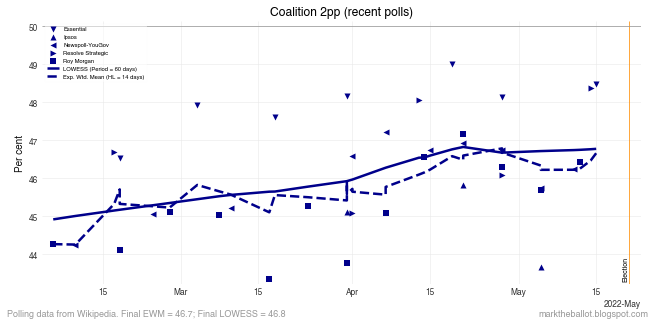

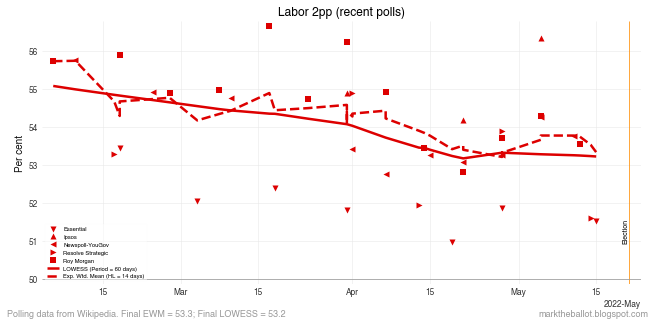

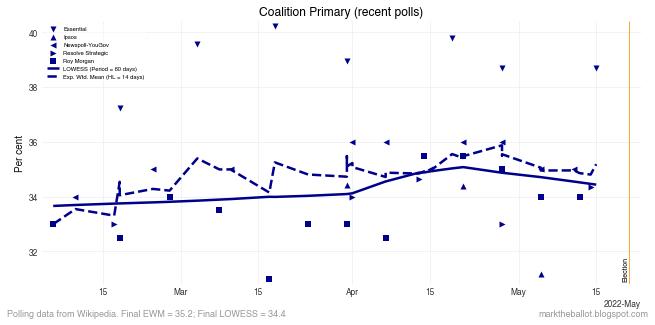

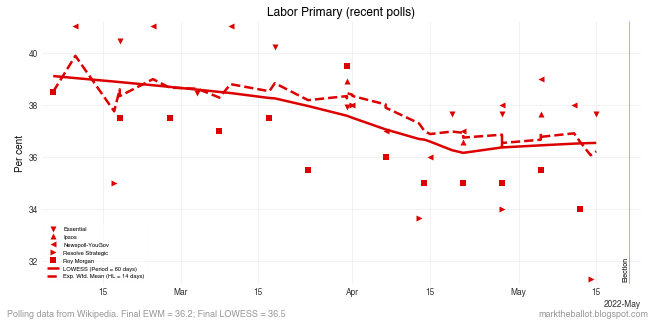

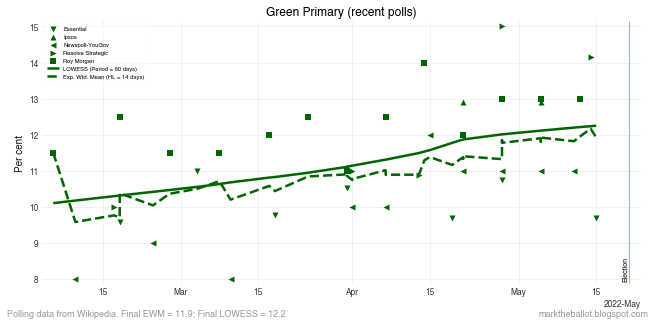

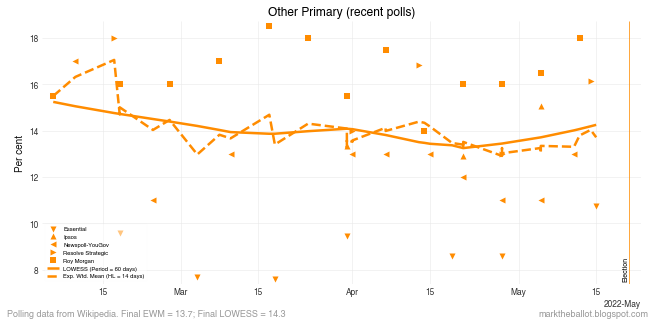

In [32]:
run = {
    'Calculated 2pp L/NP': ['Coalition 2pp', COLOR_COALITION, 50], 
    'Calculated 2pp ALP': ['Labor 2pp', COLOR_LABOR, 50],
    'Primary vote L/NP': ['Coalition Primary', COLOR_COALITION, None],
    'Primary vote ALP': ['Labor Primary', COLOR_LABOR, None],
    'Primary vote GRN': ['Green Primary', COLOR_GREEN, None],
    ('Primary vote ONP', 'Primary vote OTH'): ['Other Primary', COLOR_OTHER, None],
    # Last one is a tuple, because dictionaries cannot have a list as an index.
}

for column, (title, colour, hline) in run.items():
    if type(column) is tuple:
        column = list(column) # convert the tuple to a list
    plot_close(pv, column, colour, f'{title} (recent polls)', hline)

### Preferred Prime Minister

In [33]:
ppm.columns

Index(['Mean Date', 'Date', 'Brand', 'Firm', 'Interview mode', 'Sample size',
       'Preferred Prime Minister Morrison',
       'Preferred Prime Minister Albanese',
       'Preferred Prime Minister Don't Know', 'Morrison Satisfied',
       'Morrison Dissatisfied', 'Morrison Don't Know', 'Albanese Satisfied',
       'Albanese Dissatisfied', 'Albanese Don't Know'],
      dtype='object')

In [34]:
def ppm_charts(df, columns, title):

    ax = None
    no_label = False
    fig, ax = common.initiate_plot()
    for col, (name, p_color, l_color) in columns.items():
        common.add_data_points_by_pollster(ax, df, col, p_color, no_label=no_label)
        no_label = True # avoid repeated labels
        lowess = common.calculate_lowess(ppm[col], ppm['Mean Date'], period=150)
        ax.plot(lowess.index, lowess, c=l_color, lw=2.5, label=name)
    common.add_h_refence(ax, reference=50)
    ax.legend(loc='best', ncol=2)
    common.plot_finalise(ax, ylabel='Per cent', title=title, lfooter=LFOOTER, concise_dates=True)

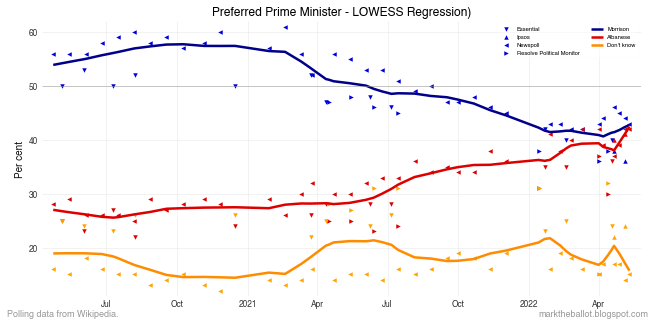

In [35]:
columns = {
    ('Preferred Prime Minister Morrison'): ['Morrison', P_COLOR_COALITION, COLOR_COALITION],    
    ('Preferred Prime Minister Albanese'): ['Albanese', P_COLOR_LABOR, COLOR_LABOR],    
    ("Preferred Prime Minister Don't Know"): ["Don't know", P_COLOR_OTHER, COLOR_OTHER],    
}

title = f'Preferred Prime Minister - LOWESS Regression)'
ppm_charts(ppm, columns, title)

### Satisfaction charts

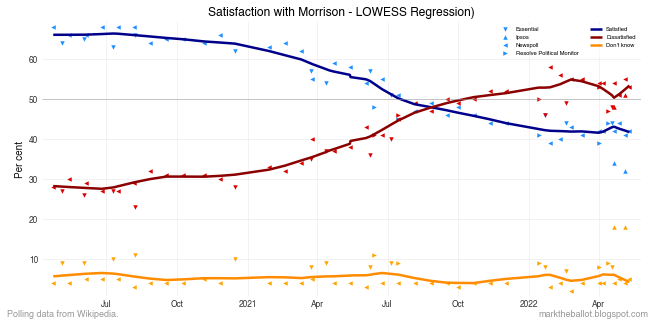

In [36]:
columns = {
    ('Morrison Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Morrison Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Morrison Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Morrison - LOWESS Regression)'
ppm_charts(ppm, columns, title)

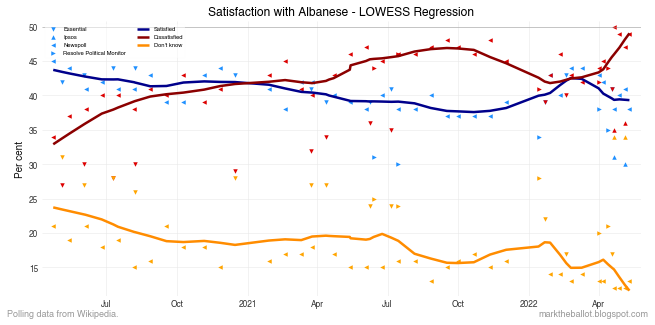

In [37]:
columns = {
    ('Albanese Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Albanese Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Albanese Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Albanese - LOWESS Regression'
ppm_charts(ppm, columns, title)

## Check for under-dispersion with poll results

### Check all - using a simple arithmetic mean

In [38]:
def tpp_recent_dispersion_check(data, column, period_days=None, last_n_polls=None):
    DATE_COL = 'Mean Date'
    SAMPLE_SIZE_COL = 'Sample size'
    PERCENT = 95
    
    # sanity checks
    assert period_days is None or last_n_polls is None
    assert not (period_days is None and last_n_polls is None)
    assert not (period_days is not None and last_n_polls is not None)
    
    # trim data to recent period
    if period_days: 
        cut_off = data[DATE_COL].max() - pd.Timedelta(days=period_days)
        data = data[data[DATE_COL] >= cut_off]
        suffix = f'polls from {cut_off.strftime("%d-%m-%Y")}'
    if last_n_polls:
        data = data.sort_values(by=DATE_COL, ascending=True)
        data = data[-last_n_polls:]
        suffix = f'last {last_n_polls} polls'

    # calculate chi-squared
    X, X_min, X_max, dof, percent = common.calc_chi_squared(data[column], 
                                        sample_sizes=data[SAMPLE_SIZE_COL], 
                                        percent=PERCENT, )
    
    # plot
    fig, ax = common.plot_chi_square(X, X_min, X_max, dof, percent=percent)
    title = (
        f'$\chi^2$ Statistic for recent polls ({column}): DOF={str(dof)} '
        f'({suffix})'
    )
    common.plot_finalise(ax, title=title, xlabel='$\chi^2$', ylabel='Probability',
                         lfooter=LFOOTER + 
                          f'Polls between {data["Mean Date"].min().strftime("%d-%m-%Y")} '
                          f'and {data["Mean Date"].max().strftime("%d-%m-%Y")} '
                          '(mean collection dates). ',
                         save_suffix=str(percent)
                        )

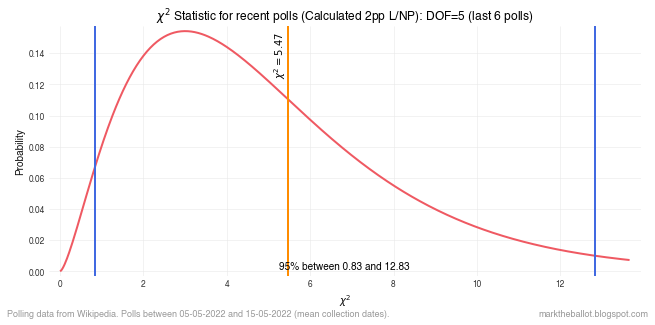

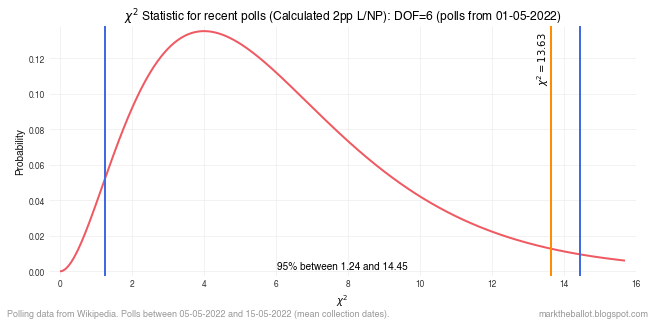

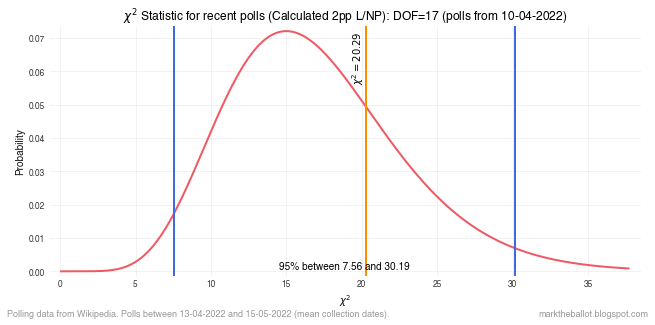

In [39]:
# let's get our 2pp series
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', last_n_polls=6)
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', period_days=14)
period = (pv['Mean Date'].max() - pd.Timestamp('2022-04-10')) / pd.Timedelta(days=1)
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', period_days=period)

### Check all pollsters but Essential - against a moving average

Noting that the Essential numbers are quite different to the other pollster numbers

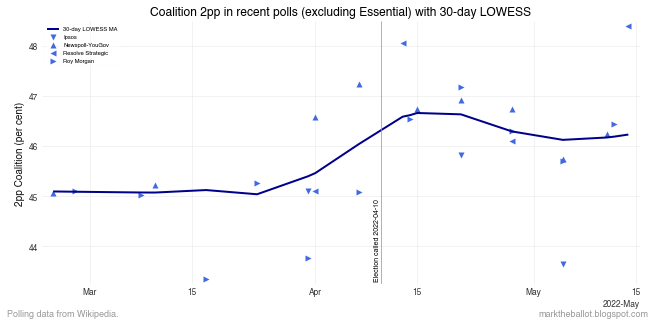

In [40]:
# set-up
EXCLUDE = 'Essential'
SPAN = 12 # weeks
SPAN_DAYS = SPAN * 7
E_CALL_DATE = '2022-04-10'
ELECTION_CALL = pd.Timestamp(E_CALL_DATE)
finish = pv['Mean Date'].max()
start = finish - pd.Timedelta(days=SPAN_DAYS)
LOWESS_PERIOD = 30 # DAYS
assert(LOWESS_PERIOD <= SPAN_DAYS)
MARKERS = ['v', '^', '<', '>', 's', 'o', 'p', 'D', 'd', ]

# data calculations
selection = pv[(pv['Mean Date'] >= start) & (pv['Brand'] != EXCLUDE)].copy()
selection['lowess 2pp'] = common.calculate_lowess(
    series=selection['Calculated 2pp L/NP'],
    times=selection['Mean Date'], 
    period=LOWESS_PERIOD).values

# plot 
fig, ax = common.initiate_plot()
ax.plot(selection['Mean Date'], selection['lowess 2pp'], lw=2, 
        c='darkblue', label=f'{LOWESS_PERIOD}-day LOWESS MA')
for i, brand in enumerate(sorted(selection['Brand'].unique())):
    data = selection[selection['Brand'] == brand]
    ax.scatter(data['Mean Date'], data['Calculated 2pp L/NP'],
               label=brand, marker=MARKERS[i], c='royalblue')
ax.axvline(ELECTION_CALL, lw=0.75, c='#999999')
ax.text(ELECTION_CALL, selection['Calculated 2pp L/NP'].min(),
        f'Election called {E_CALL_DATE}', rotation=90,
        size='x-small', ha='right')

# finalise
ax.legend(loc='upper left')
title = f'Coalition 2pp in recent polls (excluding {EXCLUDE}) with {LOWESS_PERIOD}-day LOWESS'
common.plot_finalise(ax, title=title, xlabel=None, ylabel='2pp Coalition (per cent)',
                     lfooter=LFOOTER,
                     save_suffix=str(LOWESS_PERIOD), concise_dates=True)

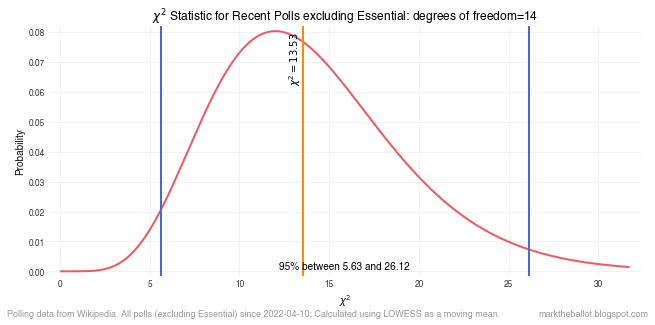

In [41]:
PERCENT = 95
# Chi-squared using LOWESS as the moving mean
chi2 = selection[selection['Mean Date'] >= ELECTION_CALL].copy()
X, X_min, X_max, dof, percent = common.calc_chi_squared(chi2['Calculated 2pp L/NP'], 
                                        sample_sizes=chi2['Sample size'], 
                                        percent=PERCENT, )

# plot
fig, ax = common.plot_chi_square(X, X_min, X_max, dof, percent=percent)
title = (
    f'$\chi^2$ Statistic for Recent Polls excluding {EXCLUDE}: '
    f'degrees of freedom={str(dof)} '
)
common.plot_finalise(ax, title=title, xlabel='$\chi^2$', ylabel='Probability',
                     lfooter=LFOOTER + 
                     f'All polls (excluding {EXCLUDE}) since {E_CALL_DATE}; '
                     'Calculated using LOWESS as a moving mean.',
                     save_suffix=str(percent),
                        )

## Save files

In [42]:
# and save to file
tpp.to_csv(f'{DATA_DIR}two_party_preferred.csv')
pv.to_csv(f'{DATA_DIR}primary_vote.csv')
ppm.to_csv(f'{DATA_DIR}preferred_prime_minister.csv')

## Check for any problems with data capture and cleaning

In [43]:
# Note you should go back and check any warnings that appear here ...
common.print_warnings()

  1: check_row_sums() found issues with 2pp vote
  2: check_row_sums() found issues with Primary vote
  3: check_row_sums() found issues with Preferred Prime Minister
  4: check_row_sums() found issues with Albanese
  5: final_sanity_check() found an issue with "2pp vote L/NP"
  6: final_sanity_check() found an issue with "2pp vote ALP"
  7: final_sanity_check() found an issue with "Primary vote L/NP"
  8: final_sanity_check() found an issue with "Primary vote OTH"
  9: There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]
